# Benchmarks for VFDT, OLIN, and IOLIN

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%reload_ext autoreload

In [6]:
import river as ri
import numpy as np
import scipy

Let's focus on a couple different data sets:
 - Agrawal with no drift
 - Agrawal with drift
 - LED with drift
 
 We will use a delay of 10 for all of these datasets, meaning that the algorithm only knows the correct answer after 10 samples have passed

We will test with several different classifiers:
 - Hoeffdinger (VFDT)
 - OLIN
 - IOLIN
 
 Notice in the results, that the OLIN and IOLIN both learn the problem with much less data than VFDT. Additionally, they are better suited for drift correction and have higher accuracy. OLIN is noticeably slower, but IOLIN trades only a little accuracy for a big speed-up. Note that the majority of the memory usage is due to the training batches which have to be maintained in the trees because of how River is designed. The trees themselves are smaller than the VFDT, generally, which can be seen by drawing the tree

## Agrawal with no drift

### VFDT

In [11]:
VFDTClf = ri.tree.HoeffdingTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"], leaf_prediction="mc")

nodrift = ri.synth.Agrawal(seed=42, perturbation = .01, classification_function = 2).take(4000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(nodrift, VFDTClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


[1,000] Accuracy: 52.02% – 00:00:00 – 27.55 KB
[2,000] Accuracy: 53.17% – 00:00:00 – 27.52 KB
[3,000] Accuracy: 54.52% – 00:00:00 – 105.72 KB
[4,000] Accuracy: 58.95% – 00:00:00 – 162.43 KB



(process:35128): Pango-WARNING **: 16:40:50.596: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


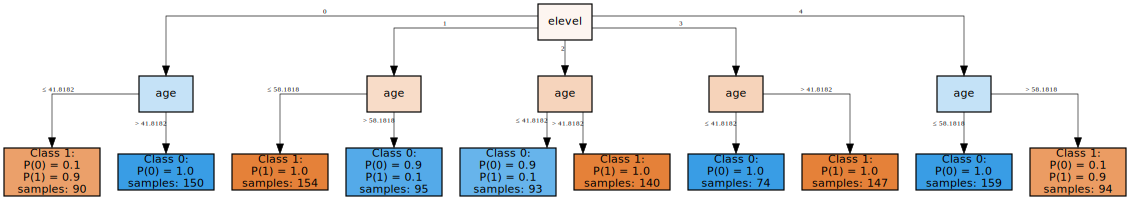

In [12]:
VFDTClf.draw()

### OLIN

In [22]:
OLINClf = ri.tree.OLINTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"],
                                     max_window = 1000,
                                     min_add_count = 50,
                                     max_add_count = 400,
                                     inc_add_count = 20,
                                     red_add_count = 10,
                                     alpha = 0.001,
                                     max_err = 0.6,)

nodrift = ri.synth.Agrawal(seed=42, perturbation = .01, classification_function = 2).take(4000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(nodrift, OLINClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


[1,000] Accuracy: 82.92% – 00:00:01 – 1.82 MB
[2,000] Accuracy: 91.33% – 00:00:04 – 2.5 MB
[3,000] Accuracy: 94.11% – 00:00:06 – 2.42 MB
[4,000] Accuracy: 95.45% – 00:00:08 – 2.52 MB



(process:36280): Pango-WARNING **: 16:46:11.270: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


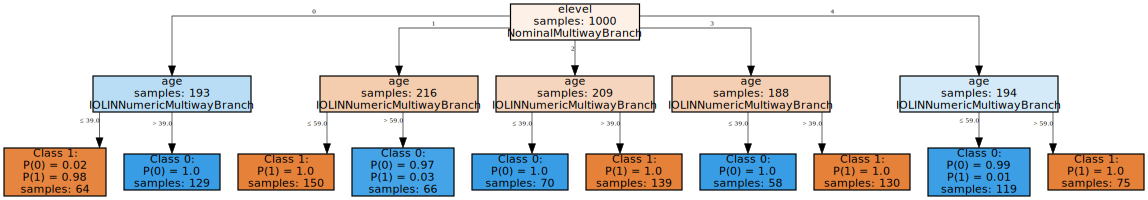

In [23]:
OLINClf.draw()

### IOLIN

In [20]:
IOLINClf = ri.tree.IOLINTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"],
                                       max_window = 1000,
                                       min_add_count = 50,
                                       max_add_count = 400,
                                       inc_add_count = 20,
                                       red_add_count = 10,
                                       alpha = 0.001,
                                       max_err = 0.6,)

nodrift = ri.synth.Agrawal(seed=42, perturbation = .01, classification_function = 2).take(4000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(nodrift, IOLINClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


attempt_to_split()
Children stats after att_to_spl
Added new Layer
no drift
IOLINLeafMajorityClass
calling update_IN()
calling buildIN on updateIN
attempt_to_split()
Children stats after att_to_spl
Added new Layer
out
no drift
IOLINLeafMajorityClass
calling update_IN()
calling buildIN on updateIN
attempt_to_split()
Children stats after att_to_spl
Added new Layer
out
no drift
IOLINLeafMajorityClass
calling update_IN()
calling buildIN on updateIN
attempt_to_split()
Children stats after att_to_spl
Added new Layer
out
no drift
IOLINLeafMajorityClass
calling update_IN()
calling buildIN on updateIN
attempt_to_split()
Children stats after att_to_spl
Added new Layer
out
drift detected
no drift
IOLINLeafMajorityClass
calling update_IN()
calling buildIN on updateIN
attempt_to_split()
tree weight 50.0
MI in att_to_spl 0.1952558992251071
children stats in att_to_spl [{1: 4.0, 0: 14.0}, {1: 1.0, 0: 1.0}, {1: 2.0}]
thresholds in att_to_slp: [228419.941464791, 240438.3633817443]
Children stats after 


(process:33024): Pango-WARNING **: 16:46:22.025: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


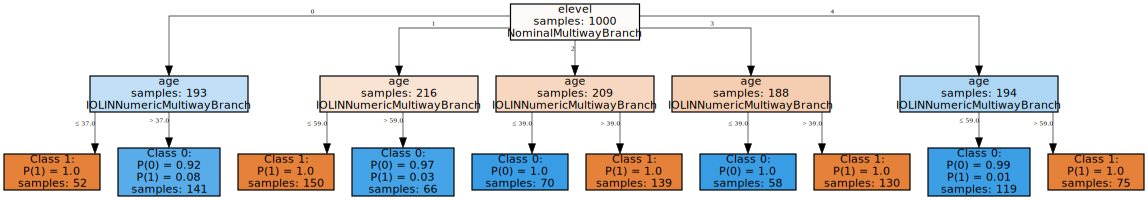

In [24]:
IOLINClf.draw()

### Results

As can be seen, OLIN and IOLIN outperform the VFDT, but at the expense of time. The memory usage is inflated because we have to maintain the batches internally, but the trees are similar sizes to eachother. IOLIN performs just a little worse than OLIN, and takes about half of the time

## Agrawal with drift
For this dataset, we are using two Agrawal streams, but with different classification functions and levels of noise. This means that the classifiers have to adapt halfway through the stream. Also note that the noise level in the first half of the stream is 25%, which makes for a difficult problem and low accuracies

### VFDT

In [25]:
VFDTClf = ri.tree.HoeffdingTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"], leaf_prediction="mc")

stream = ri.synth.ConceptDriftStream(stream=ri.synth.Agrawal(seed=42, 
                                                             perturbation = .25, classification_function =0),
                                     drift_stream=ri.synth.Agrawal(seed=42, 
                                                                   perturbation = .1, classification_function = 2),
                                     seed=42, position=2500,
                                     width=200).take(5000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(stream, VFDTClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


[1,000] Accuracy: 68.08% – 00:00:00 – 27.5 KB
[2,000] Accuracy: 66.43% – 00:00:00 – 27.5 KB
[3,000] Accuracy: 64.45% – 00:00:00 – 27.49 KB
[4,000] Accuracy: 61.75% – 00:00:00 – 395.06 KB
[5,000] Accuracy: 60.26% – 00:00:01 – 401.99 KB



(process:27720): Pango-WARNING **: 16:49:09.583: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


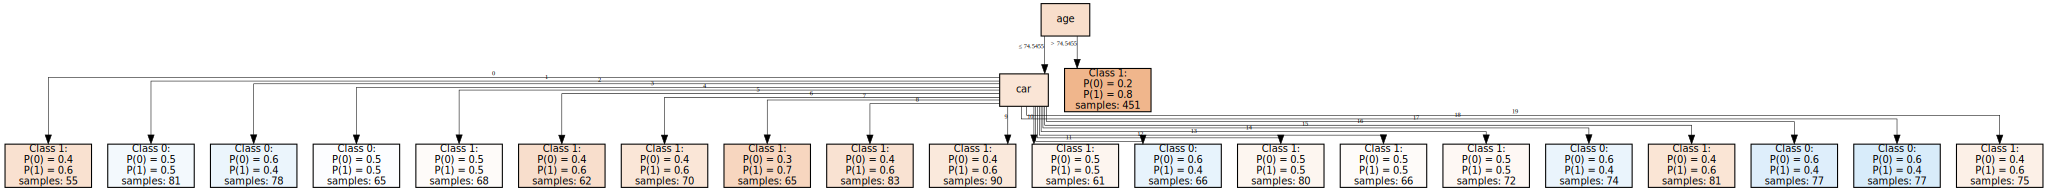

In [26]:
VFDTClf.draw()

### OLIN

In [27]:
OLINClf = ri.tree.OLINTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"],
                                     max_window = 1000,
                                     min_add_count = 50,
                                     max_add_count = 400,
                                     inc_add_count = 20,
                                     red_add_count = 10,
                                     alpha = 0.001,
                                     max_err = 0.6,)

stream = ri.synth.ConceptDriftStream(stream=ri.synth.Agrawal(seed=42, 
                                                             perturbation = .25, classification_function =0),
                                     drift_stream=ri.synth.Agrawal(seed=42, 
                                                                   perturbation = .1, classification_function = 2),
                                     seed=42, position=2500,
                                     width=200).take(5000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(stream, OLINClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


[1,000] Accuracy: 64.89% – 00:00:00 – 770.43 KB
[2,000] Accuracy: 64.64% – 00:00:03 – 1.98 MB
[3,000] Accuracy: 63.23% – 00:00:05 – 1.9 MB
[4,000] Accuracy: 65.66% – 00:00:06 – 2.53 MB
[5,000] Accuracy: 71.38% – 00:00:08 – 2.45 MB



(process:37432): Pango-WARNING **: 16:50:50.769: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


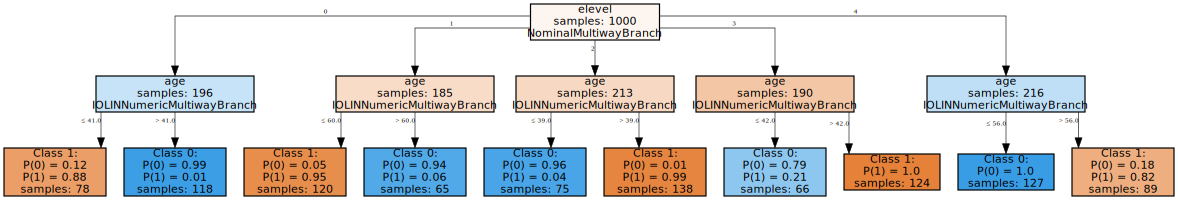

In [29]:
OLINClf.draw()

### IOLIN

In [30]:
IOLINClf = ri.tree.IOLINTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"],
                                       max_window = 1000,
                                       min_add_count = 50,
                                       max_add_count = 400,
                                       inc_add_count = 20,
                                       red_add_count = 10,
                                       alpha = 0.001,
                                       max_err = 0.6,)

stream = ri.synth.ConceptDriftStream(stream=ri.synth.Agrawal(seed=42, 
                                                             perturbation = .25, classification_function =0),
                                     drift_stream=ri.synth.Agrawal(seed=42, 
                                                                   perturbation = .1, classification_function = 2),
                                     seed=42, position=2500,
                                     width=200).take(5000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(stream, IOLINClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


attempt_to_split()
Children stats after att_to_spl
Added new Layer
no drift
IOLINLeafMajorityClass
calling update_IN()
calling buildIN on updateIN
attempt_to_split()
Children stats after att_to_spl
Added new Layer
out
no drift
IOLINLeafMajorityClass
calling update_IN()
calling buildIN on updateIN
attempt_to_split()
tree weight 54.0
MI in att_to_spl 0.14719879794205637
children stats in att_to_spl [{1: 2.0}, {0: 2.0, 1: 1.0}, {1: 11.0}]
thresholds in att_to_slp: [60.0, 67.0]
Children stats after att_to_spl
{}
{}
{}
attempt_to_split()
Children stats after att_to_spl
{1: 22.0, 0: 16.0}
{0: 3.0, 1: 2.0}
{1: 11.0}
Added new Layer
out
no drift
IOLINNumericMultiwayBranch
Root is branch
check split val
MI: 0.15481284991141298
branch stats: {1: 35.0, 0: 19.0}
children stats: [{1: 22.0, 0: 16.0}, {0: 3.0, 1: 2.0}, {1: 11.0}]
critical val: 13.815510557964274
branch weight: 54.0
tree weight: 54.0
unsplit branch (root)
calling update_IN()
calling buildIN on updateIN
attempt_to_split()
tree weight 5

attempt_to_split()
Children stats after att_to_spl
{0: 115.0, 1: 86.0}
{1: 115.0, 0: 77.0}
{0: 63.0, 1: 132.0}
{1: 130.0, 0: 61.0}
{1: 84.0, 0: 137.0}
Added new Layer
out
[4,000] Accuracy: 64.77% – 00:00:05 – 2.51 MB
no drift
NominalMultiwayBranch
Root is branch
check split val
check split val
check split val
check split val
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 10
attempt_to_split()
Added a new layer
no drift
NominalMultiwayBranch
Root is branch
check split val
check split val
check split val
check split val
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 10
attempt_to_split()
Added a new layer
no drift
NominalMultiwayBranch
Root is branch
check split val
check split val
check split val
check split val
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 10
attempt_to_split()
Added a new layer
[5,000] Accuracy: 70.77% – 00:00:06 – 4.24 MB



(process:30984): Pango-WARNING **: 16:51:11.742: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


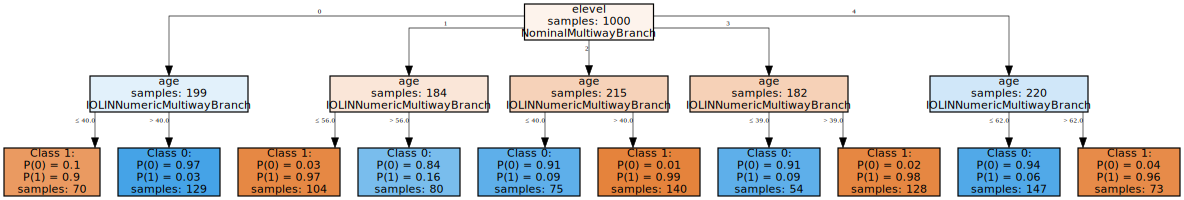

In [31]:
IOLINClf.draw()

### Results

Again, we find that OLIN and IOLIN outperformt he VFDT. The difference is smaller this time, because of the difficulty of the problem with such a high level of noise. Notice again that the IOLIN tree is faster than OLIN, but with only a minor hit to accuracy

## LED with drift

### VFDT

In [39]:
VFDTClf = ri.tree.HoeffdingTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"], leaf_prediction="mc")

stream = ri.synth.LEDDrift(seed = 42, noise_percentage = 0.1,
                          irrelevant_features= True, n_drift_features=4).take(4000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(stream, VFDTClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


[1,000] Accuracy: 10.71% – 00:00:00 – 166.04 KB
[2,000] Accuracy: 10.40% – 00:00:00 – 166.04 KB
[3,000] Accuracy: 10.17% – 00:00:01 – 166.04 KB
[4,000] Accuracy: 9.95% – 00:00:01 – 166.04 KB



(process:28580): Pango-WARNING **: 16:54:36.666: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


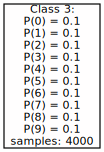

In [40]:
VFDTClf.draw()

### OLIN

In [37]:
OLINClf = ri.tree.OLINTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"],
                                     max_window = 1000,
                                     min_add_count = 50,
                                     max_add_count = 400,
                                     inc_add_count = 20,
                                     red_add_count = 10,
                                     alpha = 0.001,
                                     max_err = 0.6,)

stream = ri.synth.LEDDrift(seed = 42, noise_percentage = 0.1,
                          irrelevant_features= True, n_drift_features=4).take(4000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(stream, OLINClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


[1,000] Accuracy: 46.85% – 00:00:03 – 1.64 MB
[2,000] Accuracy: 56.84% – 00:00:07 – 2.11 MB
[3,000] Accuracy: 59.93% – 00:00:09 – 1.86 MB
[4,000] Accuracy: 61.82% – 00:00:10 – 2.12 MB



(process:11732): Pango-WARNING **: 16:54:27.882: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


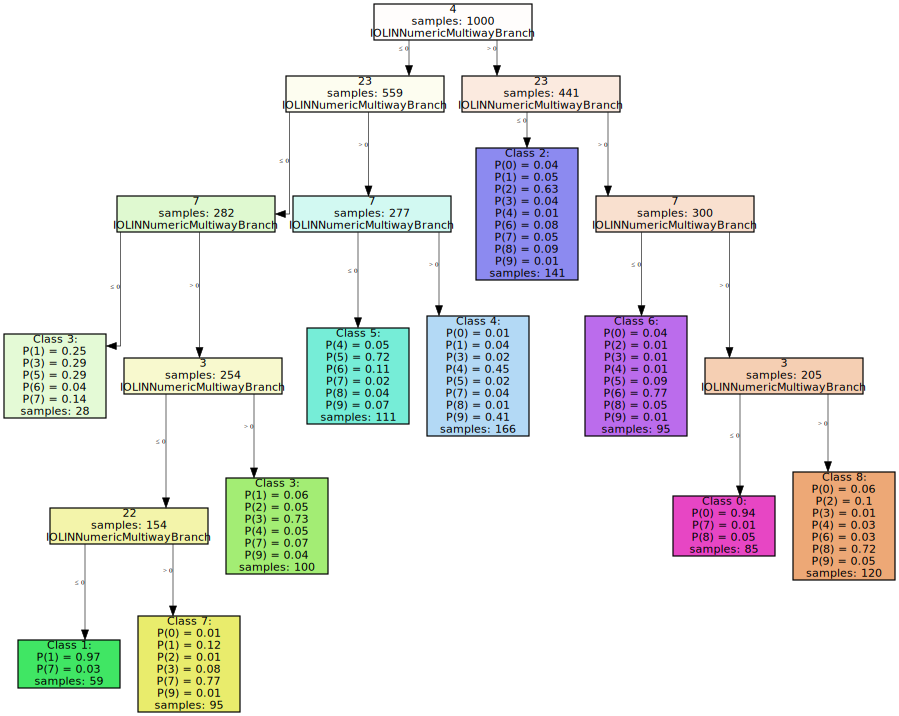

In [38]:
OLINClf.draw()

### IOLIN

In [36]:
IOLINClf = ri.tree.IOLINTreeClassifier(nominal_attributes = ["elevel", "car", "zipcode"],
                                       max_window = 1000,
                                       min_add_count = 50,
                                       max_add_count = 400,
                                       inc_add_count = 20,
                                       red_add_count = 10,
                                       alpha = 0.001,
                                       max_err = 0.6,)

stream = ri.synth.LEDDrift(seed = 42, noise_percentage = 0.28,
                          irrelevant_features= True, n_drift_features=4).take(4000)

randTreeMetric = ri.metrics.Accuracy()
ri.evaluate.progressive_val_score(stream, IOLINClf, randTreeMetric,
                                  print_every = 1000, show_time = True, show_memory = True, delay=10);


attempt_to_split()
tree weight 50.0
MI in att_to_spl 0.3655881298100252
children stats in att_to_spl [{7: 4.0, 1: 3.0, 0: 3.0, 6: 4.0, 3: 1.0, 5: 1.0, 4: 2.0}, {7: 1.0, 8: 4.0, 1: 1.0, 9: 7.0, 0: 1.0, 6: 4.0, 3: 5.0, 5: 1.0, 4: 3.0, 2: 5.0}]
thresholds in att_to_slp: [0]
Children stats after att_to_spl
{}
{}
attempt_to_split()
tree weight 50.0
MI in att_to_spl 0.44245071375322986
children stats in att_to_spl [{8: 1.0, 9: 1.0, 6: 2.0, 3: 5.0, 4: 1.0, 2: 4.0, 5: 1.0}, {7: 1.0, 8: 3.0, 1: 1.0, 9: 6.0, 6: 2.0, 4: 2.0, 0: 1.0, 2: 1.0}]
thresholds in att_to_slp: [0]
Children stats after att_to_spl
{0: 3.0, 6: 4.0, 7: 4.0, 5: 1.0, 1: 3.0, 4: 2.0, 3: 1.0}
{7: 1.0, 8: 4.0, 1: 1.0, 9: 7.0, 6: 4.0, 3: 5.0, 4: 3.0, 0: 1.0, 2: 5.0, 5: 1.0}
attempt_to_split()
Children stats after att_to_spl
{0: 3.0, 6: 4.0, 7: 4.0, 5: 1.0, 1: 3.0, 4: 2.0, 3: 1.0}
{7: 1.0, 8: 4.0, 1: 1.0, 9: 7.0, 6: 4.0, 3: 5.0, 4: 3.0, 0: 1.0, 2: 5.0, 5: 1.0}
Added new Layer
no drift
IOLINNumericMultiwayBranch
Root is branch
check s

Added a new layer
no drift
IOLINNumericMultiwayBranch
Root is branch
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 2
attempt_to_split()
Added a new layer
no drift
IOLINNumericMultiwayBranch
Root is branch
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 2
attempt_to_split()
Added a new layer
no drift
IOLINNumericMultiwayBranch
Root is branch
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 2
attempt_to_split()
Added a new layer
no drift
IOLINNumericMultiwayBranch
Root is branch
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 2
attempt_to_split()
Added a new layer
no drift
IOLINNumericMultiwayBranch
Root is branch
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 2
attempt_to_split()
Added a new layer
no drift
IOLINNumericMultiwayBranch
Root is branch
check split val
check split val
calling update_IN()
IOLINLeafMajorityClass
in 2
attempt_to_

AttributeError: 'NoneType' object has no attribute 'nominal_attributes'


(process:30984): Pango-WARNING **: 16:51:11.742: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


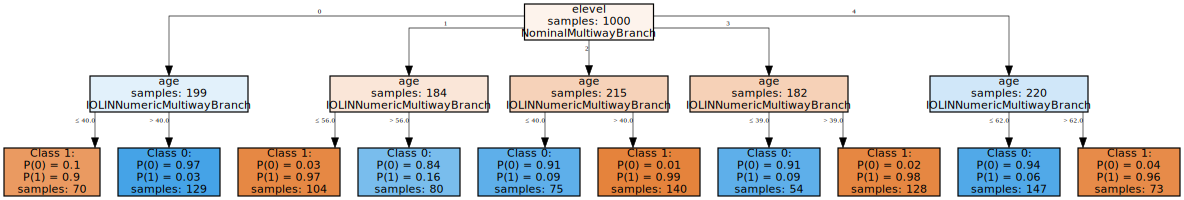

In [31]:
IOLINClf.draw()

### Results

Again, we find that OLIN and IOLIN outperform the VFDT. The difference is much larger in this dataset because VFDT is not well built to handle the randomness in the data. The tree from OLIN is much better than the stump produced by VFDT. We also perform much better with drift. Notice again that the IOLIN tree is faster than OLIN, but with only a minor hit to accuracy

# Take Aways

As can be seen in our benchmarks, OLIN and IOLIN outperform the native VFDT in every data set. Although OLIN is slower, IOLIN has a much faster performance with only a minor hit to performance. This aligns with what was indicated in the original source papers. The size of the trees is also generally better, but this isn't reflected as well in River because we have to adapt a batched training paradigm which takes storage room. Additionally, the VFDT implemented by River has pruning mechanisms which make the tree smaller than it would otherwise be in a native VFDT.

All told, however, we are pleased with the performance and results of our algoirthms!